In [81]:
# Import required modules.
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

## Exploratory Data Analysis

In [3]:
# Read the data into de.
de = pd.read_csv('../data/MIT-BIH_Arrhythmia_Database.csv')

In [4]:
# Show the head of de.
de.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


In [5]:
# Show the shape of de.
de.shape

(100689, 34)

In [6]:
# Check for duplicates in de.
de[de.duplicated()].sum()

record              0
type                0
0_pre-RR            0
0_post-RR         0.0
0_pPeak           0.0
0_tPeak           0.0
0_rPeak           0.0
0_sPeak           0.0
0_qPeak           0.0
0_qrs_interval      0
0_pq_interval       0
0_qt_interval       0
0_st_interval       0
0_qrs_morph0      0.0
0_qrs_morph1      0.0
0_qrs_morph2      0.0
0_qrs_morph3      0.0
0_qrs_morph4      0.0
1_pre-RR            0
1_post-RR         0.0
1_pPeak           0.0
1_tPeak           0.0
1_rPeak           0.0
1_sPeak           0.0
1_qPeak           0.0
1_qrs_interval      0
1_pq_interval       0
1_qt_interval       0
1_st_interval       0
1_qrs_morph0      0.0
1_qrs_morph1      0.0
1_qrs_morph2      0.0
1_qrs_morph3      0.0
1_qrs_morph4      0.0
dtype: object

 - No duplicates found

In [7]:
# Check for missing values in de.
de.isnull().sum()

record            0
type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      0
dtype: int64

 - No missing values shown

In [8]:
# Drop the record column.
de = de.drop(labels='record', axis=1)

In [9]:
# Get the statistics o de.
ds = de.describe().round()

In [10]:
# Show statistics of the first 16 columns.
ds.iloc[:, :16]

,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,0_st_interval,0_qrs_morph0,0_qrs_morph1,0_qrs_morph2,0_qrs_morph3,0_qrs_morph4
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,279.0,279.0,0.0,0.0,1.0,-0.0,-0.0,28.0,11.0,60.0,20.0,-0.0,0.0,0.0,1.0,0.0
std,82.0,81.0,0.0,1.0,1.0,1.0,0.0,15.0,9.0,40.0,30.0,0.0,0.0,1.0,1.0,1.0
min,11.0,6.0,-3.0,-2.0,-2.0,-4.0,-4.0,0.0,1.0,5.0,1.0,-4.0,-3.0,-3.0,-3.0,-3.0
25%,230.0,230.0,-0.0,-0.0,1.0,-1.0,-0.0,18.0,5.0,33.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0
50%,267.0,266.0,0.0,0.0,1.0,-1.0,-0.0,27.0,7.0,46.0,8.0,-0.0,-0.0,0.0,0.0,0.0
75%,324.0,322.0,0.0,1.0,1.0,1.0,-0.0,38.0,16.0,75.0,23.0,-0.0,0.0,1.0,1.0,1.0
max,2114.0,2114.0,4.0,4.0,4.0,4.0,3.0,170.0,150.0,334.0,141.0,3.0,3.0,3.0,3.0,3.0


In [11]:
# Show statistics of the last 17 columns.
ds.iloc[:, 17:]

,1_post-RR,1_pPeak,1_tPeak,1_rPeak,1_sPeak,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,279.0,0.0,0.0,-0.0,-0.0,-0.0,11.0,10.0,36.0,14.0,-0.0,-0.0,-0.0,-0.0,-0.0
std,81.0,0.0,0.0,1.0,1.0,0.0,12.0,9.0,17.0,9.0,0.0,0.0,1.0,1.0,1.0
min,6.0,-2.0,-2.0,-4.0,-6.0,-5.0,0.0,1.0,5.0,1.0,-5.0,-4.0,-4.0,-4.0,-5.0
25%,230.0,-0.0,0.0,-0.0,-1.0,-1.0,3.0,5.0,25.0,10.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,266.0,0.0,0.0,-0.0,-0.0,-0.0,7.0,8.0,33.0,12.0,-0.0,-0.0,-0.0,-0.0,-0.0
75%,322.0,0.0,1.0,0.0,-0.0,-0.0,18.0,13.0,45.0,17.0,-0.0,-0.0,0.0,0.0,-0.0
max,2114.0,5.0,7.0,4.0,3.0,4.0,260.0,185.0,412.0,215.0,4.0,4.0,3.0,4.0,3.0


In [12]:
# Define numerical columns and split into two sets.
col_num = de.drop(columns="type").columns.to_list()
set_one = col_num[:16]
set_two = col_num[17:]

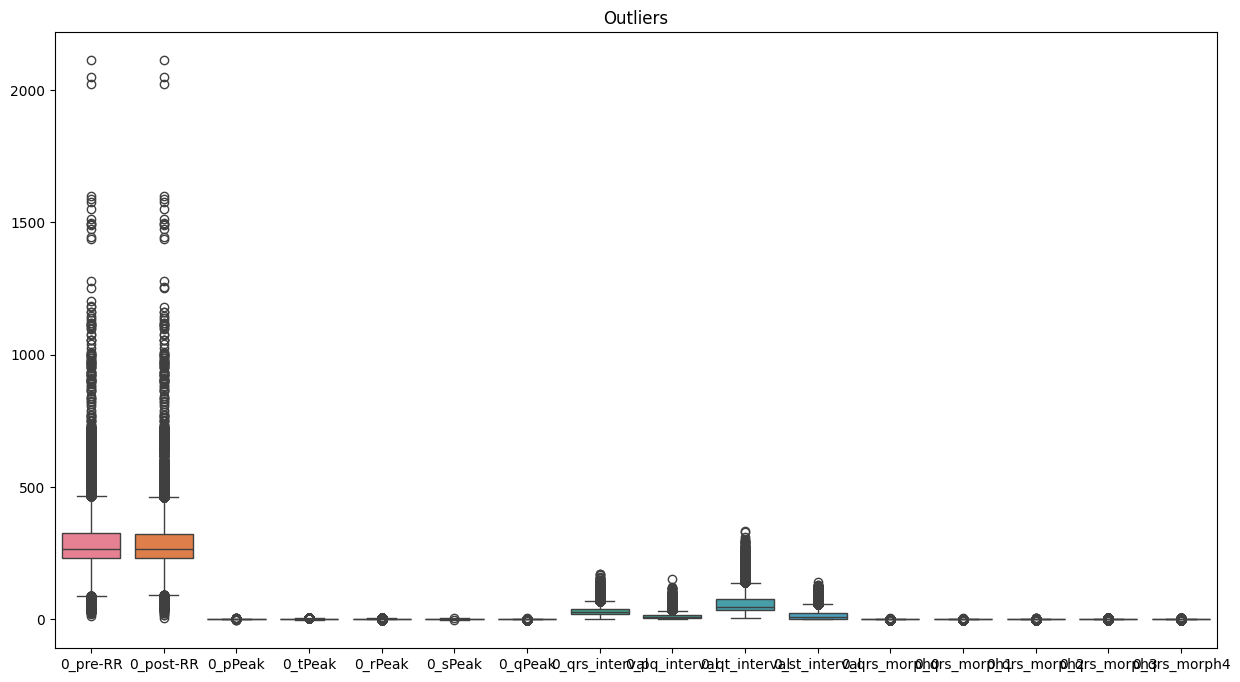

In [13]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
plt.title('Outliers')
sns.boxplot(data=de[set_one]);

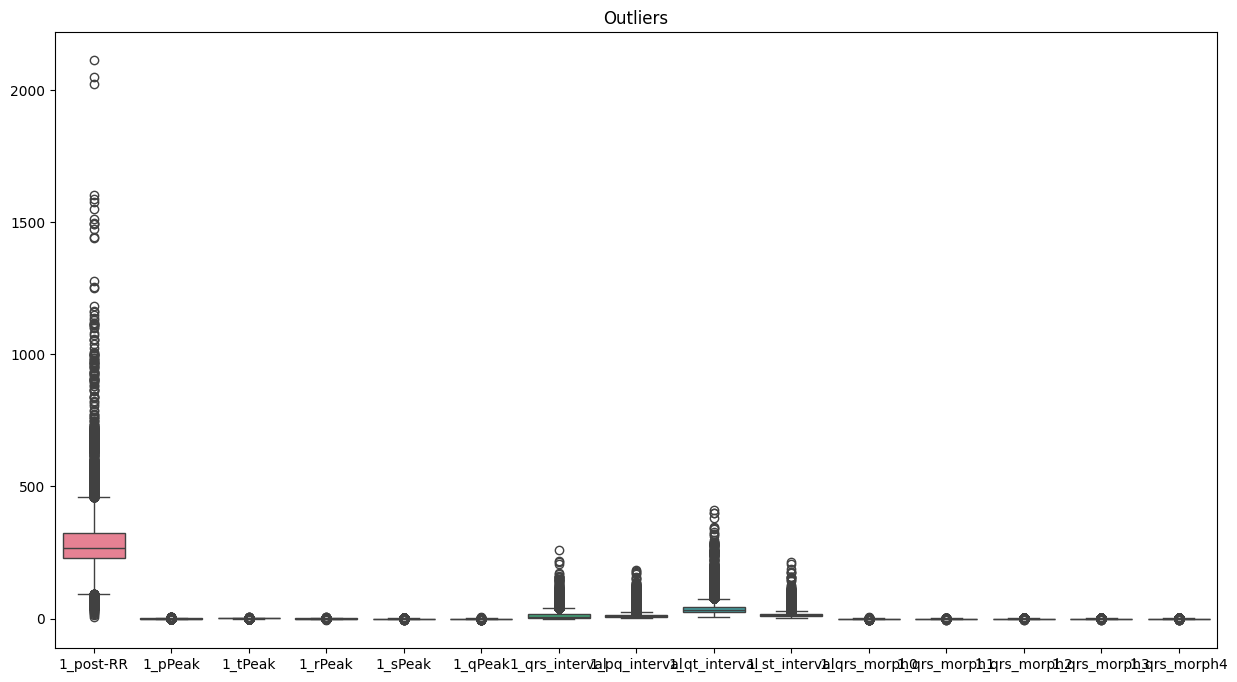

In [14]:
# Draw boxplot of the second set.
plt.figure(figsize=(15, 8))
plt.title('Outliers')
sns.boxplot(data=de[set_two]);

In [15]:
# Check for correletion.
corr = de[col_num].corr().round(2)

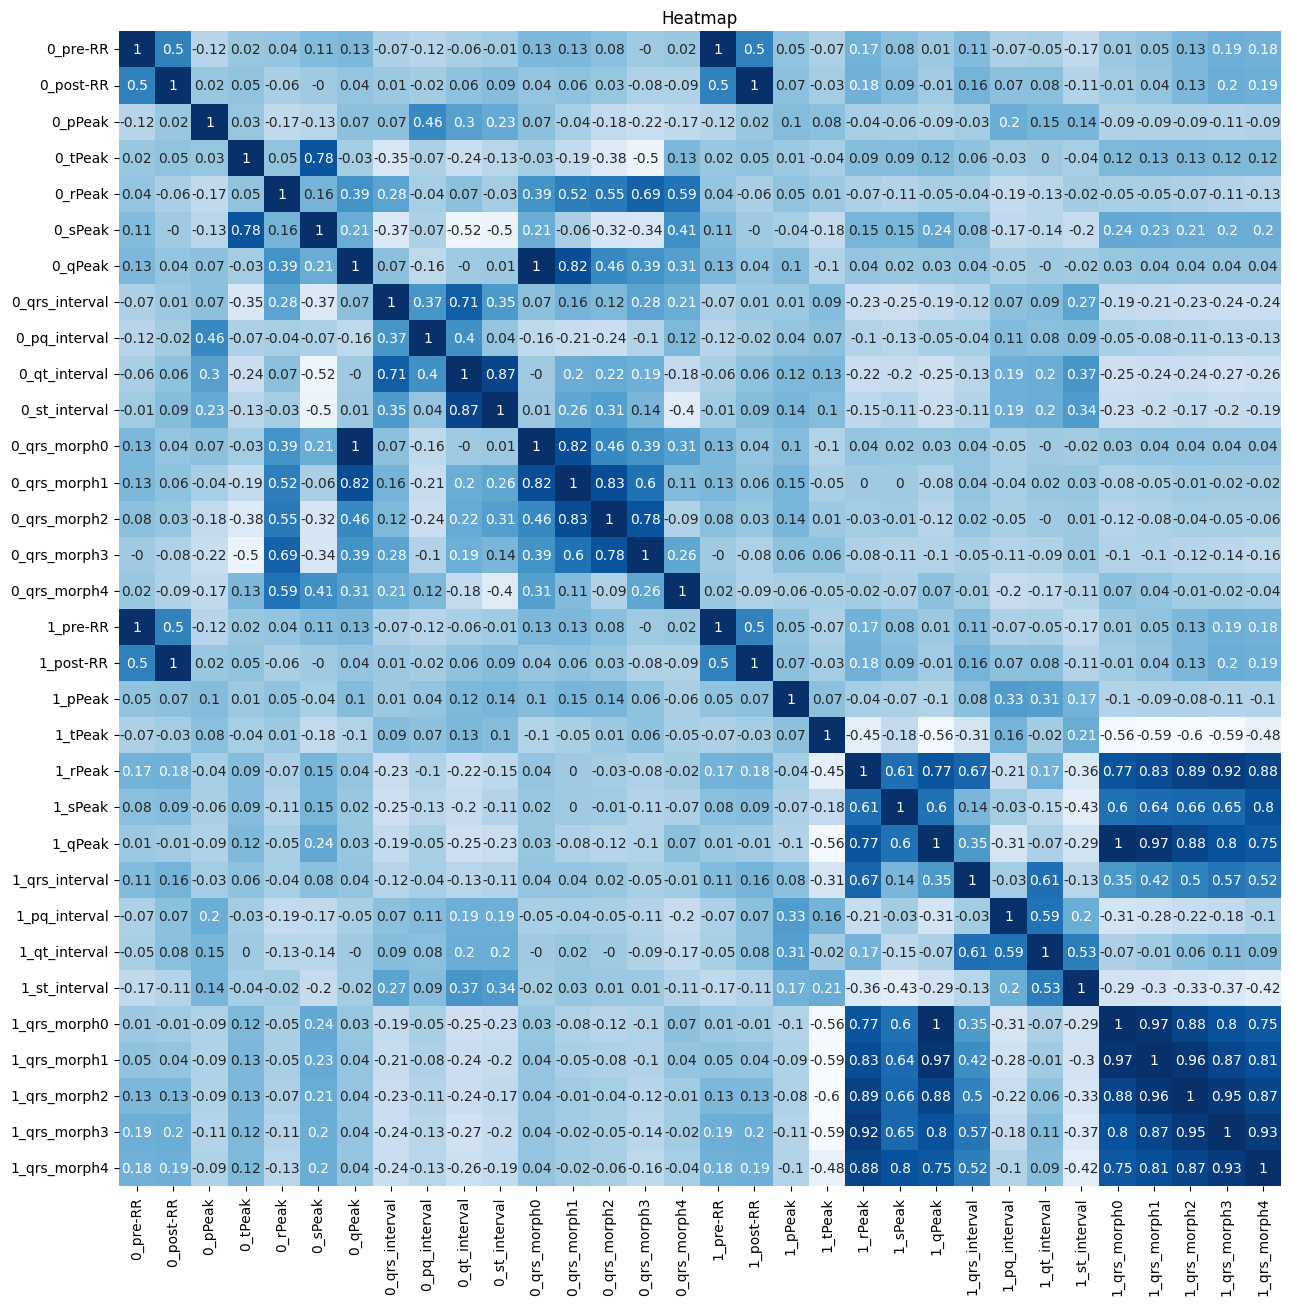

In [16]:
# Draw the correlation heatmap.
plt.figure(figsize=(15, 15))
plt.title('Heatmap')
sns.heatmap(corr, cmap='Blues', annot=True, cbar=False);

In [17]:
# Unstack the correlation values.
du = corr.unstack().sort_values(ascending=False)

In [18]:
# Check the length of df_unstack.
len(du)

1024

In [19]:
# Show the first 40 records of df_unstack.
du[:40]

1_qrs_morph3    1_qrs_morph3      1.0
1_qrs_morph2    1_qrs_morph2      1.0
0_pre-RR        1_pre-RR          1.0
0_qPeak         0_qPeak           1.0
1_qrs_interval  1_qrs_interval    1.0
0_pPeak         0_pPeak           1.0
1_rPeak         1_rPeak           1.0
1_sPeak         1_sPeak           1.0
1_qPeak         1_qrs_morph0      1.0
                1_qPeak           1.0
1_qrs_morph0    1_qrs_morph0      1.0
                1_qPeak           1.0
1_st_interval   1_st_interval     1.0
0_post-RR       1_post-RR         1.0
1_pq_interval   1_pq_interval     1.0
1_qt_interval   1_qt_interval     1.0
1_qrs_morph1    1_qrs_morph1      1.0
0_post-RR       0_post-RR         1.0
0_pq_interval   0_pq_interval     1.0
1_qrs_morph4    1_qrs_morph4      1.0
0_pre-RR        0_pre-RR          1.0
0_sPeak         0_sPeak           1.0
0_qrs_interval  0_qrs_interval    1.0
0_qrs_morph1    0_qrs_morph1      1.0
0_qrs_morph0    0_qrs_morph0      1.0
0_qrs_morph3    0_qrs_morph3      1.0
1_pre-RR    

In [20]:
# Show the next 40 records of df_unstack.
du[41:80]

1_qrs_morph1   1_qPeak          0.97
1_qPeak        1_qrs_morph1     0.97
1_qrs_morph1   1_qrs_morph0     0.97
1_qrs_morph2   1_qrs_morph1     0.96
1_qrs_morph1   1_qrs_morph2     0.96
1_qrs_morph3   1_qrs_morph2     0.95
1_qrs_morph2   1_qrs_morph3     0.95
1_qrs_morph4   1_qrs_morph3     0.93
1_qrs_morph3   1_qrs_morph4     0.93
               1_rPeak          0.92
1_rPeak        1_qrs_morph3     0.92
1_qrs_morph2   1_rPeak          0.89
1_rPeak        1_qrs_morph2     0.89
1_qrs_morph0   1_qrs_morph2     0.88
1_rPeak        1_qrs_morph4     0.88
1_qPeak        1_qrs_morph2     0.88
1_qrs_morph4   1_rPeak          0.88
1_qrs_morph2   1_qPeak          0.88
               1_qrs_morph0     0.88
0_st_interval  0_qt_interval    0.87
1_qrs_morph1   1_qrs_morph3     0.87
0_qt_interval  0_st_interval    0.87
1_qrs_morph4   1_qrs_morph2     0.87
1_qrs_morph3   1_qrs_morph1     0.87
1_qrs_morph2   1_qrs_morph4     0.87
1_rPeak        1_qrs_morph1     0.83
1_qrs_morph1   1_rPeak          0.83
0

In [21]:
# Check the value counts of the target column.
de['type'].value_counts()

type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: count, dtype: int64

 - N represents normal while VEB, SVEB, F, and Q represents arrhythmia

In [22]:
# Transform multi-class labels into binary-class (1 and 0).
de['type'] = de['type'].map({'N': 0, 'VEB': 1, 'SVEB': 1, 'F': 1, 'Q': 1})

In [23]:
# Check the value counts of the target column.
de['type'].value_counts()

type
0    90083
1    10606
Name: count, dtype: int64

In [77]:
#  Create a function to split the data.
def split_data(df):
    
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_full_train = df_full_train['type'].values
    y_test = df_test['type'].values
    y_train = df_train['type'].values
    y_val = df_val['type'].values

    del df_full_train['type']
    del df_test['type']
    del df_train['type']
    del df_val['type']
    
    dv = DictVectorizer(sparse=False)

    full_train_dicts = df_full_train.to_dict(orient='records')
    test_dicts = df_test.to_dict(orient='records')
    train_dicts = df_train.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')
    
    X_full_train = dv.fit_transform(full_train_dicts)
    X_test = dv.transform(test_dicts)    
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    return  X_full_train, X_test, X_train, X_val, y_full_train, y_test, y_train, y_val, dv

In [58]:
# Create function to train the model.
def train_model(alg):
    _, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)
    model = alg.fit(X_train, y_train)
    
    return model, X_val, y_val

In [65]:
# Create function to predict probability.
def predict_proba(model, X_val, y_val):
    y_pred = model.predict_proba(X_val)[:, 1]
    score = round(roc_auc_score(y_val, y_pred), 4)

    return score, y_pred

## Logistic Regression

### Train Model

In [43]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Define the algorithm.
alg_lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [36]:
# Train the model.
mod_lr, X_val, y_val = train_model(alg_lr)

In [38]:
# Calculate the probability ROC AUC score.
score_lr, y_pred = predict_proba(mod_lr, X_val, y_val)
print(f'score_lr = {round(score_lr, 4)}')

score_lr = 0.9488


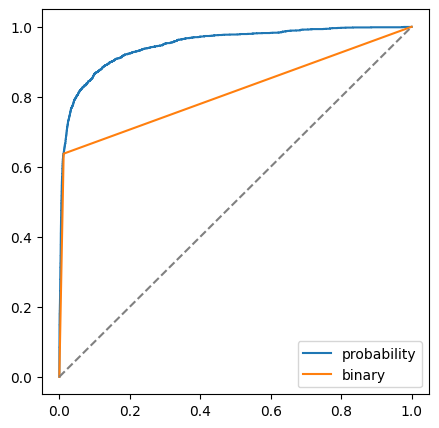

In [42]:
# Show the ROC curve.
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

### Confusion Matrix

In [45]:
# Define confusion_matrix_dataframe function.
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [46]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2124,18014,0,0
10,0.1,1843,1849,281,16165
20,0.2,1684,795,440,17219
30,0.3,1551,452,573,17562
40,0.4,1437,321,687,17693
50,0.5,1354,221,770,17793
60,0.6,1277,162,847,17852
70,0.7,1142,123,982,17891
80,0.8,976,90,1148,17924
90,0.9,664,54,1460,17960


### Precision and Recall

In [51]:
# Calculate the precision and recall.
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

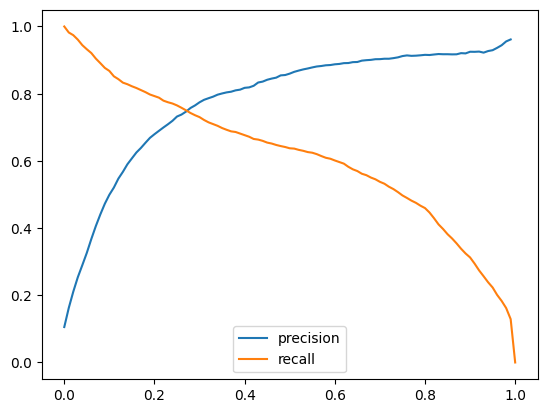

In [52]:
# Plot the curves.
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

### F1 Score

In [53]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

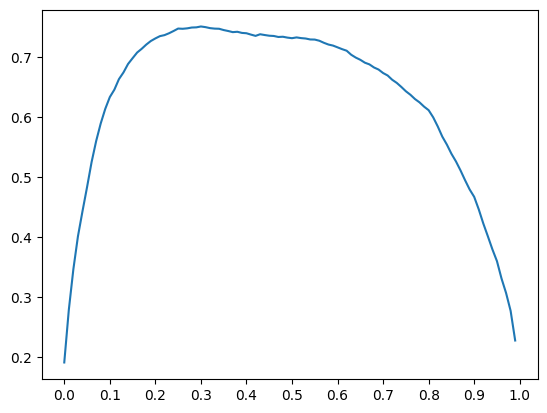

In [54]:
# Plot the F1 scores.
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [57]:
# Get the maximum f1-score.
f1_max_lr = df_scores['f1'].max()
print(f'f1_max_lr = {round(f1_max_lr, 4)}')

np.float64(0.7516355706324206)

## Random Forest Classifier

### Train Model

In [60]:
# Copy the data to be used.
df = de.copy()

In [61]:
# Define the algorithm.
alg_rf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)

In [66]:
# Train the model.
mod_rf, X_val, y_val = train_model(alg_rf)

In [67]:
# Calculate the probability ROC AUC score.
score_rf, y_pred = predict_proba(mod_rf, X_val, y_val)
print(f'score_rf = {round(score_rf, 4)}')

score_rf = 0.9986


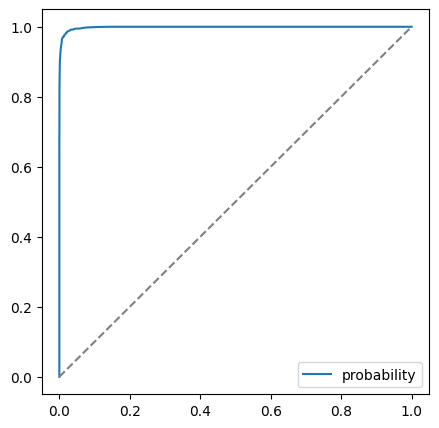

In [68]:
# Plot the ROC curve.
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

### Confusion Matrix

In [69]:
# Define confusion_matrix_dataframe function.
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [70]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2124,18014,0,0
10,0.1,2111,766,13,17248
20,0.2,2088,370,36,17644
30,0.3,2061,201,63,17813
40,0.4,2024,112,100,17902
50,0.5,1969,56,155,17958
60,0.6,1906,24,218,17990
70,0.7,1813,13,311,18001
80,0.8,1692,6,432,18008
90,0.9,1427,1,697,18013


### Precision and Recall

In [71]:
# Calculate the precision and recall.
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

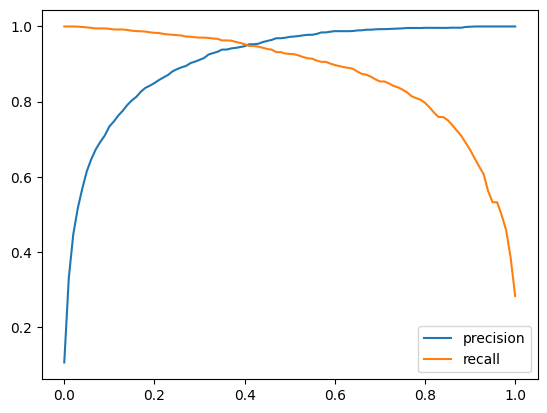

In [72]:
# Plot the curves.
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

### F1 Score

In [73]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

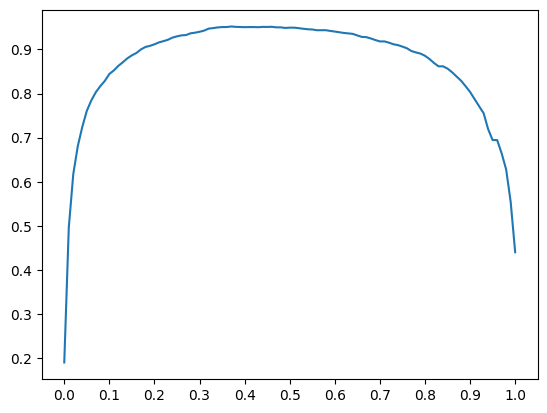

In [74]:
# Plot the F1 scores.
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [76]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

np.float64(0.9518)

### XGB Classifier

In [ ]:
# Copy the data to be used.
df = de.copy()

In [79]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, dv = split_data(df)

In [82]:
# Create the features.
features = dv.feature_names_
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

In [83]:
# Create the DMatrix.
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [84]:
# Define the parameters.
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [85]:
# Train the model.
mod_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [87]:
# Calculate the probability ROC AUC score.
y_pred = mod_xgb.predict(dval)
score_xgb = round(roc_auc_score(y_val, y_pred), 4)
print(f'score_xgb = {score_xgb}')

score_xgb = 0.9933


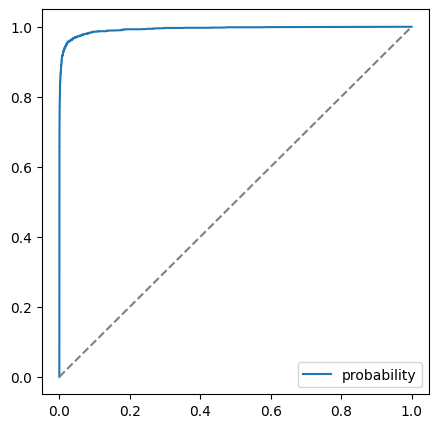

In [88]:
# Plot the ROC curve.
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

### Confusion Matrix

In [89]:
# Define confusion_matrix_dataframe function.
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [90]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2124,18014,0,0
10,0.1,2041,578,83,17436
20,0.2,1993,266,131,17748
30,0.3,1951,166,173,17848
40,0.4,1916,117,208,17897
50,0.5,1868,84,256,17930
60,0.6,1823,56,301,17958
70,0.7,1776,36,348,17978
80,0.8,1677,23,447,17991
90,0.9,1433,6,691,18008


### Precision and Recall

In [92]:
# Calculate the precision and recall.
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

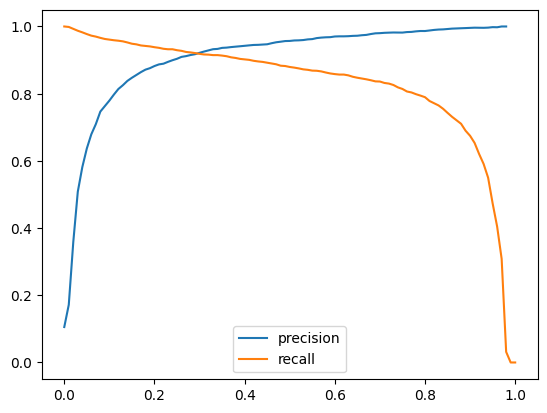

In [93]:
# Plot the curves.
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

### F1 Score

In [94]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

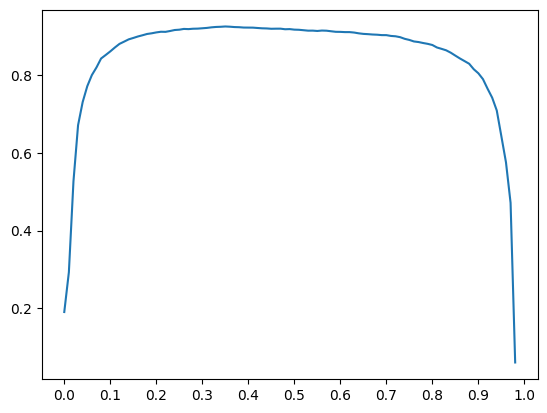

In [95]:
# Plot the F1 scores.
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [101]:
# Get the maximum f1-score.
f1_max_xgb = df_scores['f1'].max()
print(f'f1_max_xgb = {round(f1_max_xgb, 4)}')

f1_max_xgb = 0.9247


## Tune Model

### Logistic Regression

In [110]:
# Copy the data to be used.
df = de.copy()

In [111]:
columns = [
    '0_pre-RR', '0_post-RR', '0_pPeak', '0_tPeak', '0_rPeak',
    '0_sPeak', '0_qPeak', '0_qrs_interval', '0_pq_interval',
    '0_qt_interval', '0_st_interval', '0_qrs_morph0', '0_qrs_morph1',
    '0_qrs_morph2', '0_qrs_morph3', '0_qrs_morph4', '1_pre-RR', '1_post-RR',
    '1_pPeak', '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak', '1_qrs_interval',
    '1_pq_interval', '1_qt_interval', '1_st_interval', '1_qrs_morph0',
    '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4'
]

In [113]:
# Split the data.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [114]:
# Create function to train the kfold.
def train_kfold(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [115]:
# Create function to predict the kfold.
def predict_kfold(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [117]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['type'].values
    y_val = df_val['type'].values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.946 +- 0.005


In [119]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['type'].values
        y_val = df_val['type'].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.931 +- 0.009
C=   1, 0.947 +- 0.005
C=  10, 0.947 +- 0.009


 - The best C is 1

## Feature Importances

### Logistic Regression

In [129]:
# Copy the data to be used.
df = de.copy()

In [130]:
# Split the data.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [131]:
# Apply the feature elimination technique.
original_score = score_lr
scores = pd.DataFrame(columns=['eliminated_feature', 'score_lr', 'difference'])
features = df_train.drop(labels='type', axis=1).columns.to_list()

for feature in features:
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train['type'].values
    y_val = df_val['type'].values
    
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[subset].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    val_dict = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    y_pred = model.predict(X_val)
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

In [132]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=True)

,eliminated_feature,score_lr,difference
2,0_pPeak,0.816482,0.132318
17,1_post-RR,0.814418,0.134382
9,0_qt_interval,0.814363,0.134437
10,0_st_interval,0.814280,0.134520
26,1_st_interval,0.814239,0.134561
14,0_qrs_morph3,0.814183,0.134617
0,0_pre-RR,0.814155,0.134645
6,0_qPeak,0.813712,0.135088
30,1_qrs_morph3,0.813449,0.135351
27,1_qrs_morph0,0.813435,0.135365
